In [1]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

In [3]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='IPython')

In [4]:
def bic_score(x, pa):
    l = gm.information.discrete_mutual_information(data[[x]], data[pa]) - gm.information.discrete_entropy(data[[x]])
    n = data.shape[0]
    k = np.prod(true_dgm.factor(x).table.shape) - 1
    result = -n*l + 0.5 * np.log(n) * k
    return result

In [5]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'alarm.bif'))
true_dgm.draw()

In [6]:
data = true_dgm.rvs(100000)

In [7]:
from graphmodels.information import discrete_entropy, discrete_mutual_information

In [8]:
from itertools import product
class MatrixGraph:
    def __init__(self, adjacency_matrix, names_to_idx=None):
        self.adj = adjacency_matrix
        self.names_to_idx = names_to_idx
        if names_to_idx is None:
            self.names_to_idx = {i:i for i in range(adj.shape[0])}
            
    @property
    def n(self):
        return self.adj.shape[0]
    
    @property
    def m(self):
        return np.sum(self.adj)
    
    @property
    def names(self):
        idx_to_names = self.idx_to_names
        return [idx_to_names[i] for i in range(self.n)]
    
    def nodes(self):
        return list(range(self.n))
    
    @property
    def idx_to_names(self):
        return {i:node for node, i in self.names_to_idx.items()}
    
    @staticmethod
    def from_networkx_DiGraph(graph):
        names_to_idx = {node:i for i, node in enumerate(graph.nodes())}
        adj = np.zeros((len(names_to_idx), len(names_to_idx)))
        for u, v in graph.edges():
            adj[names_to_idx[u], names_to_idx[v]] = 1
        return MatrixGraph(adj, names_to_idx=names_to_idx)

    def to_networkx_DiGraph(self):
        result = nx.DiGraph()
        result.add_nodes_from(self.names_to_idx.keys())
        for i, j in product(range(self.n), repeat=2):
            if self.adj[i, j]:
                result.add_edge(self.idx_to_names[i], self.idx_to_names[j])
        return result
    
    def is_acyclic(self):
        return nx.is_directed_acyclic_graph(self.to_networkx_DiGraph())
    
    def draw(self):
        return gm.DGM(self.to_networkx_DiGraph()).draw()

In [124]:
class ScoreBIC:
    def __init__(self, graph, data):
        self.graph = graph
        self.data = data
        self.n_values = {name: len(self.data[name].value_counts()) for name in self.data.columns}
        self.cache = {}
        
    def _footprint(self, node, parents):
        return tuple([node] + list(parents))
        
    def __call__(self, node, parents):
        fp = self._footprint(node, parents)
        if fp in self.cache:
            return self.cache[fp]
        
        pa_names = [self.graph.idx_to_names[idx] for idx, exists in enumerate(parents) if exists]
        node_name = self.graph.idx_to_names[node]
            
        k = self.n_values[node_name]*np.prod([self.n_values[pa_i] for pa_i in pa_names]) - 1
        n = self.data.shape[0]
        l = n*discrete_mutual_information(data[[node_name]], data[pa_names])
        
        result = l - 0.5 * np.log(n) * k
        self.cache[fp] = result
        return result

    def total(self):
        score = 0.
        for node in self.graph.nodes():
            pa = self.graph.adj[:, node].copy()
            score += self(node, pa)
        return score

In [106]:
from sklearn.svm import SVR
class SVRScoreBIC:
    def __init__(self, graph, data, C=1.0):
        self.graph = graph
        self.data = data
        self.n_values = {name: len(self.data[name].value_counts()) for name in self.data.columns}
        self.cache = {}
        self.model = {node: SVR(epsilon=1e-5, C=C) for node in self.graph.nodes()}
        self.traces = {node: [] for node in self.graph.nodes()}
    
    def _make_pa_short(self, node, parents):
        pa_short = list(parents)
        pa_short.pop(node)
        return tuple(pa_short)
    
    def _read_cache(self, node, parents):
        pa_short = self._make_pa_short(node, parents)
        return self.cache[node][pa_short]
        
    def _write_cache(self, node, parents, value):
        pa_short = self._make_pa_short(node, parents)
        if node not in self.cache:
            self.cache[node] = {}
        self.cache[node][pa_short] = value
    
    def _in_cache(self, node, parents):
        pa_short = self._make_pa_short(node, parents)
        if node not in self.cache:
            return False
        if pa_short not in self.cache[node]:
            return False
        return True
    
    def _model_predict(self, node, parents):
        pa_short = self._make_pa_short(node, parents)
        return self.model[node].predict(np.array(pa_short))
    
    def true(self, node, parents, trace=True):
        if self._in_cache(node, parents):
            return self._read_cache(node, parents)
        
        pa_names = [self.graph.idx_to_names[idx] for idx, exists in enumerate(parents) if exists]
        node_name = self.graph.idx_to_names[node]
            
        k = self.n_values[node_name]*np.prod([self.n_values[pa_i] for pa_i in pa_names]) - 1
        n = self.data.shape[0]
        l = n*discrete_mutual_information(data[[node_name]], data[pa_names])
        
        result = l - 0.5 * np.log(n) * k
        
        if trace: self.traces[node].append((self._model_predict(node, parents), result))
        
        self._write_cache(node, parents, result)
        return result
        
    def predicted(self, node, parents):
        if self._in_cache(node, parents):
            return self._read_cache(node, parents)
        return self._model_predict(node, parents)
    
    def __call__(self, *args, **kwargs):
        method = kwargs['method']
        del kwargs['method']
        return getattr(self, method)(*args, **kwargs)
    
    def relearn(self):
        for node in self.cache.keys():
            X, y = zip(*self.cache[node].items())
            self.model[node].fit(X, y)
        return self
    
    def total(self):
        score = 0.
        for node in self.graph.nodes():
            pa = self.graph.adj[:, node].copy()
            score += self.true(node, pa)
        return score

In [11]:
mxg = MatrixGraph.from_networkx_DiGraph(true_dgm)
score = ScoreBIC(mxg, data)

In [12]:
score(1, [0, 0, 0, 0, 0])

-11.512925464970229

In [13]:
score(1, [0, 0, 1, 0, 0])

-41.874508889740518

In [14]:
score(1, [1, 0, 1, 0, 0])

-91.318923220851744

In [15]:
score(4, [0, 0, 0, 0, 0])

-11.512925464970229

In [16]:
class InvalidOperation(Exception): pass

class LocalOperation:
    def __init__(self, graph, fscore):
        self.graph = graph
        self.fscore = fscore
    
    def do(self):
        raise NotImplementedError()
    
    def undo(self):
        raise NotImplementedError()
        
    def score(self, **kwargs):
        raise NotImplementedError()

In [17]:
class AddEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst
    
    def do(self):
        if self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 0
            raise InvalidOperation()
        return self
    
    def undo(self):
        self.graph.adj[self.src, self.dst] = 0
        return self
    
    def score(self, **kwargs):
        pa = self.graph.adj[:, self.dst].copy()
        score = -self.fscore(self.dst, pa, **kwargs)
        pa[self.src] = 1
        score += self.fscore(self.dst, pa, **kwargs)
        return score

In [18]:
class RemoveEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst
    
    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        return self
    
    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        return self
    
    def score(self, **kwargs):
        pa = self.graph.adj[:, self.dst].copy()
        score = -self.fscore(self.dst, pa, **kwargs)
        pa[self.src] = 0
        score += self.fscore(self.dst, pa, **kwargs)
        return score

In [19]:
class ReverseEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst
        
    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        self.graph.adj[self.dst, self.src] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 1
            self.graph.adj[self.dst, self.src] = 0
            raise InvalidOperation()
        return self
    
    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        self.graph.adj[self.dst, self.src] = 0
        return self
    
    def score(self, **kwargs):
        pa = self.graph.adj[:, self.dst].copy()
        score = -self.fscore(self.dst, pa, **kwargs)
        pa[self.src] = 0
        score += self.fscore(self.dst, pa, **kwargs)
        
        pa = self.graph.adj[:, self.src].copy()
        score -= self.fscore(self.src, pa, **kwargs)
        pa[self.dst] = 1
        score += self.fscore(self.src, pa, **kwargs)
        return score

In [20]:
mxg = MatrixGraph.from_networkx_DiGraph(true_dgm)
score = ScoreBIC(mxg, data)

In [21]:
mxg.draw()

In [22]:
op = AddEdge(mxg, score, 0, 3)
op.score

<bound method AddEdge.score of <__main__.AddEdge object at 0x7f273de42f98>>

In [23]:
mxg.adj[0, 1] = 1

In [24]:
op = RemoveEdge(mxg, score, 0, 1)
op.score()

67.087890482303919

In [25]:
op.do()

In [26]:
op.score()

0.0

In [27]:
from itertools import product, permutations
class GreedySearch:
    def __init__(self, graph, fscore):
        self.graph = graph
        self.fscore = fscore
        self.ops = []
        self.ops += [AddEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [RemoveEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [ReverseEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        
    def iteration(self):
        [op.score() for op in self.ops]
        self.ops.sort(reverse=True, key=lambda op: op.score(method='true'))
        for op in self.ops:
            if op.score(method='true') < 0:
                return True
            try:
                op.do()
                return False
            except InvalidOperation:
                pass
        return True
    
    def __call__(self):
        while not self.iteration():
            pass

In [140]:
from itertools import chain
class GreedySearchRVM:
    def __init__(self, graph, fscore):
        self.graph = graph
        self.fscore = fscore
        self.ops = []
        self.ops += [AddEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [RemoveEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [ReverseEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        
    def iteration(self):
        self.ops.sort(reverse=True, key=lambda op: op.score(method='predicted'))
        best_ops = self.ops[:100]
        best_ops.sort(reverse=True, key=lambda op: op.score(method='true'))
        self.fscore.relearn()
        for op in chain(best_ops, self.ops[100:]):
            if op.score(method='true') < 0:
                continue
            try:
                op.do()
                return False
            except InvalidOperation:
                pass
        return True
    
    def __call__(self):
        while not self.iteration():
            pass

In [141]:
true_dgm.draw()

In [142]:
mx = MatrixGraph.from_networkx_DiGraph(true_dgm)
mx.adj = np.zeros(mx.adj.shape)
#mx.draw()

In [143]:
def generate_subset(nargs, kmin=1, kmax=4, size=1):
    """
    Generate `size` random subsets of parents for node `target` with factor `factor` 
    and calculate discrete mutual information for them.
    Number of parents lies between kmin and kmax
    """
    
    n = np.random.randint(low=kmin, high=kmax+1, size=size)
    result = []
    score = []
    for i, cn in enumerate(n):
        current = np.random.choice(range(nargs), size=cn, replace=False)
        result.append([1.0 if arg in current else 0.0 for arg in range(nargs)])
    return np.vstack(result)

In [144]:
score = SVRScoreBIC(mx, data, C=1e+8)

In [145]:
%load_ext line_profiler
from __future__ import print_function
import sys
def burnin(mx, score):
    for node in mx.nodes():
        print(node, end=' ')
        sys.stdout.flush()
        X = generate_subset(mx.n - 1, size=100)
        y = []
        for x in X:
            x = np.hstack([x[:node], [0], x[node:]])
            y.append(score.true(node, x, trace=False))
        score.model[node].fit(X, y)
        
%lprun -f SVRScoreBIC.true burnin(mx, score)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 

In [147]:
gs = GreedySearchRVM(mx, score)

In [148]:
score.model[0]

SVR(C=100000000.0, cache_size=200, coef0=0.0, degree=3, epsilon=1e-05,
  gamma=0.0, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [149]:
for i in range(100):
    gs.iteration()
    print(gs.fscore.total())

60860.7719412
113499.510333
165575.978908
216837.078253
263963.951595
309387.524921
354618.071777
397753.881268
437936.403001
474493.527921
510440.195055
542032.260144
573398.363722
604641.076994
635840.098441
663935.921345
688464.531626
710092.313358
729959.59091
747596.815482
764100.382205
778968.982285
793414.474153
807661.144346
821902.111023
834987.436937
847224.162214
858151.535155
870952.078012
881636.385944
892041.929008
901287.587697
910176.440751
918269.938496
924652.750701
930718.931521
936629.711344
945475.016234
949933.031104
954312.016808
958487.660668
962435.969063
965122.388747
968239.907773
968424.83198
969857.747345
971491.543552
975417.517387
977506.861192
977511.743691
979376.71625
981194.473002
982199.556709
984346.813373
985964.497521
987011.411479
988173.105224
989082.202802
989860.743128
989921.442533
990299.28323
990571.952212
990571.952212
990571.952212
990571.952212
990571.952212
990571.952212
990571.952212
990571.952212
990571.952212
990571.952212
990571.952

In [151]:
%lprun -f AddEdge.do gs.iteration()

In [89]:
gs()

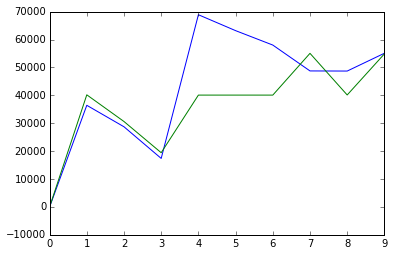

In [164]:
plt.plot(score.traces[6])

In [165]:
np.argmax([len(trace) for trace in score.traces.values()])

7

In [166]:
%lprun -f AddEdge.score gs.iteration()

In [152]:
mx.draw()

In [153]:
res_dgm = mx.to_networkx_DiGraph()

In [154]:
for node in true_dgm.nodes():
    print(node, true_dgm.predecessors(node), res_dgm.predecessors(node))

CATECHOL ['ARTCO2', 'INSUFFANESTH', 'SAO2', 'TPR'] ['ARTCO2', 'HR']
LVEDVOLUME ['LVFAILURE', 'HYPOVOLEMIA'] ['LVFAILURE', 'HYPOVOLEMIA']
HRSAT ['ERRCAUTER', 'HR'] ['ERRCAUTER', 'ARTCO2']
CVP ['LVEDVOLUME'] ['LVEDVOLUME']
SAO2 ['PVSAT', 'SHUNT'] ['PVSAT', 'SHUNT']
PVSAT ['VENTALV', 'FIO2'] ['VENTALV', 'FIO2']
HRBP ['ERRLOWOUTPUT', 'HR'] ['ERRLOWOUTPUT', 'HR']
ARTCO2 ['VENTALV'] ['VENTTUBE']
HREKG ['ERRCAUTER', 'HR'] ['ERRCAUTER', 'HRSAT']
INSUFFANESTH [] []
VENTTUBE ['DISCONNECT', 'VENTMACH'] ['DISCONNECT', 'VENTMACH']
INTUBATION [] ['VENTALV', 'EXPCO2', 'VENTLUNG']
PCWP ['LVEDVOLUME'] ['LVEDVOLUME']
HISTORY ['LVFAILURE'] ['LVFAILURE']
PULMEMBOLUS [] []
SHUNT ['INTUBATION', 'PULMEMBOLUS'] ['INTUBATION', 'PULMEMBOLUS']
TPR ['ANAPHYLAXIS'] ['CATECHOL', 'VENTLUNG', 'SAO2']
STROKEVOLUME ['LVFAILURE', 'HYPOVOLEMIA'] ['LVFAILURE', 'LVEDVOLUME', 'HYPOVOLEMIA']
VENTMACH ['MINVOLSET'] ['MINVOLSET']
DISCONNECT [] []
PRESS ['INTUBATION', 'KINKEDTUBE', 'VENTTUBE'] ['INTUBATION', 'VENTTUBE', 'KINKED

In [155]:
gm.DGM(res_dgm).is_I_map(true_dgm)

False

In [156]:
true_dgm.is_I_map(gm.DGM(res_dgm))

False